# Why GPUs matter

Let's compare GPU vs CPU performance at training a network...

Of course, this notebook will only run on a machine with a TensorFlow-supported gpu. I tested in on a AWS g2 instance.

In [ ]:
# for DSX, need to switch to the right directory. Detect using path name.
s = %pwd
if s.startswith('/gpfs'):
    %cd ~/deep-learning-workshop/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import time

# for making plots prettier
import seaborn as sns 
sns.set_style('white')

In [3]:
from __future__ import print_function
np.random.seed(1337)  # for reproducibility

In [4]:
# We'll need to use tensorflow directly to tell it to train on CPU or GPU
import tensorflow as tf

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [5]:
batch_size = 128
nb_classes = 10
nb_epoch = 3

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [6]:
import notmnist
notmnist_path = "~/data/notmnist/notMNIST.pickle"

# the data, shuffled and split between train, validation, and test sets
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = notmnist.load_data(notmnist_path)

# Reshape inputs to be flat, convert labels to 1-hot encoding.

# Reshape to have an extra dimension (useless for our black&white images, useful for RGB)
x_train = x_train.reshape(-1, img_rows, img_cols, 1)
x_valid = x_valid.reshape(-1, img_rows, img_cols, 1)
x_test = x_test.reshape(-1, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'valid samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 valid samples
10000 test samples


In [7]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [8]:
# Helper function to make same model twice, once on CPU, then on GPU
def make_model():
    model = Sequential()
    
    # Here, we're making _convolutional_ network. We'll learn the details
    # in future sessions. The key is that it requires lots of parallelizable 
    # computation...
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

# CPU

In [9]:
with tf.device('/cpu:0'):
    model_cpu = make_model()

model_cpu.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [10]:
t0 = time.time()
history = model_cpu.fit(x_train, y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(x_valid, y_valid))
t1 = time.time()

total_cpu = t1-t0

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 235s - loss: 0.7324 - acc: 0.7780 - val_loss: 0.4591 - val_acc: 0.8679
Epoch 2/3
50000/50000 [==============================] - 234s - loss: 0.4728 - acc: 0.8623 - val_loss: 0.4107 - val_acc: 0.8789
Epoch 3/3
50000/50000 [==============================] - 234s - loss: 0.4246 - acc: 0.8744 - val_loss: 0.3865 - val_acc: 0.8869


# GPU

In [11]:
with tf.device('/gpu:0'):
    model_gpu = make_model()
    
model_gpu.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [13]:
t0 = time.time()
history = model_gpu.fit(x_train, y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(x_valid, y_valid))
t1 = time.time()
total_gpu = t1-t0


Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 32s - loss: 0.7178 - acc: 0.7836 - val_loss: 0.4525 - val_acc: 0.8674
Epoch 2/3
50000/50000 [==============================] - 31s - loss: 0.4773 - acc: 0.8586 - val_loss: 0.4078 - val_acc: 0.8817
Epoch 3/3
50000/50000 [==============================] - 31s - loss: 0.4263 - acc: 0.8737 - val_loss: 0.3859 - val_acc: 0.8868


In [17]:
# Ensure they got the same (modulo random noise) results
def eval_model(model):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
print("CPU:")
eval_model(model_cpu)
print("GPU:")
eval_model(model_gpu)

CPU:
Test score: 0.193013398772
Test accuracy: 0.9468
GPU:
Test score: 0.196715823737
Test accuracy: 0.9444


In [15]:
print("Times:\n\tCPU: {:.1f}s\n\tGPU: {:.1f}s".format(total_cpu, total_gpu))

Times:
	CPU: 704.2s
	GPU: 96.6s


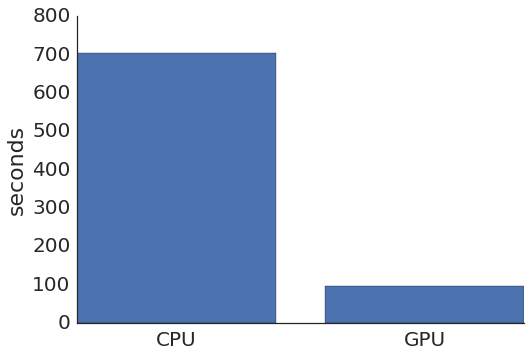

In [16]:
sns.set_context("notebook", font_scale=2)

fig, ax = plt.subplots()
ax.bar([0,1], [total_cpu, total_gpu])
ax.set_ylabel('seconds')
sns.despine(fig)
ax.set_xticks([0.4, 1.4])
ax.set_xticklabels(['CPU','GPU']);


This is just an example with a small model and our tiny 28x28 images. More complex models can see an even larger difference.